# Regression

In this chapter, we'll learn about regression. Regression is supervised learning with continuous (or sometimes discrete) labels. You are given labeled data consisting of features and labels $\{\vec{x}_i, y_i\}$. The goal is to find a function that describes their relationship, $\hat{f}(\vec{x}) = \hat{y}$. This lecture introduces some probability theory, especially expectations. You can get a refresher of [probability of random variables](https://whitead.github.io/numerical_stats/) and/or [expections](https://whitead.github.io/numerical_stats/unit_4/lectures/lecture_2.pdf). We also use and discuss [linear regression techniques](https://nbviewer.jupyter.org/github/whitead/numerical_stats/blob/master/unit_12/lectures/lecture_1.ipynb#Extending-Least-Squares-to-Multiple-Dimensions-in-Domain---OLS-ND). A more formal discussion of the concepts discussed here can be found in Chapter 3 of Bishop's Pattern Recognition and Machine Learning{cite}`bishop2006pattern`.

As usual, the code below sets-up our imports.

In [565]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
from myst_nb import glue
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
import jax
import rdkit
import warnings
warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
features_start_at = list(soldata.columns).index('MolWt')
feature_names = soldata.columns[features_start_at:]
np.random.seed(0)

## Overfitting

We'll be working again with the AqSolDB{cite}`Sorkun2019` dataset. It has about 10,000 unique compounds with measured solubility in water (label) and 17 molecular descriptors (features). we need to create a better assessment of our supervised ML models. The goal of our ML model is to predict solubility of new unseen molecules. Therefore, to assess we should test on unseen molecules. We will split our data into two: **training data** and **testing data**. Typically this is done with an 80%/20%, so that you train on 80% of your data. In our case, we'll just do 50%/50% because we have plenty of data. We'll be using a subset, 50 molecules chosen randomly, rather than the whole dataset. So we'll have 50 training molecules and 50 testing molecules.

Let's begin by seeing what effect the split of train/data has on our linear model introduced in the previous chapter. 

In [566]:
# standardize the features
soldata[feature_names] -= soldata[feature_names].mean()
soldata[feature_names] /= soldata[feature_names].std()

# Get 50 points and split into train/test
sample = soldata.sample(50, replace=False)
train = sample[:25]
test = sample[25:]

# convert from pandas dataframe to numpy arrays
x = train[feature_names].values
y = train['Solubility'].values
test_x = test[feature_names].values
test_y = test['Solubility'].values

We will again use a linear model,  $ \hat{y} = \vec{w}\vec{x} + b $. One change we'll make is using the `jit` decorator from `jax`. This decorator will tell `jax` to inspect our function, simplify it, and compile it to run quickly on a GPU (if available) or CPU. The rest of our work is the same as the previous chapter. 

```{margin}
A decorator is a python-specific syntax that modifies how a function behaves. It is
indicated with the `@` symbol. Examples include caching results, compiling the function, running 
it in parallel, and timing its execution.
```

In [567]:
# define our loss function
@jax.jit
def loss(w, b, x, y):
    return jnp.sqrt(jnp.mean((y - jnp.dot(x, w) - b)**2))
loss_grad = jax.grad(loss, (0,1))
w = np.random.normal(size=x.shape[1])
b = 0.
loss_grad(w, b, x,y)

(DeviceArray([-0.16392545,  0.13060516, -0.13970152, -0.17646873,
              -0.259215  , -0.1260821 , -0.25271794, -0.17523853,
              -0.20979491,  0.24746086, -0.3130487 , -0.4182224 ,
              -0.07118608, -0.2817901 , -0.17727517, -0.00244266,
              -0.09620093], dtype=float32),
 DeviceArray(0.67886144, dtype=float32))

Now we will train our model, again using gradient descent. This time we will not batch, since our training data only has 25 points. Can you see what the learning rate is? Why is it so different from the last chapter when we used the whole dataset?

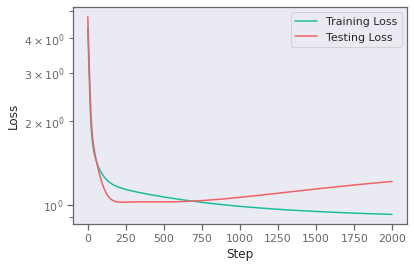

In [568]:
loss_progress = []
test_loss_progress = []
eta = 0.2
for i in range(2000):
    grad = loss_grad(w,b, x, y)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss(w, b, x, y))
    test_loss_progress.append(loss(w, b, test_x, test_y))
plt.plot(loss_progress, label='Training Loss')
plt.plot(test_loss_progress, label='Testing Loss')

plt.xlabel('Step')
plt.yscale('log')
plt.legend()
plt.ylabel('Loss')
plt.show()

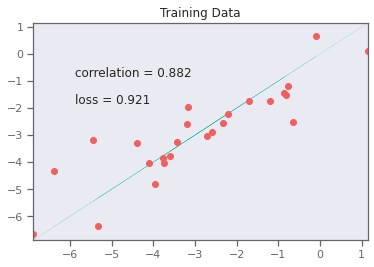

In [569]:
yhat = x @ w + b
plt.plot(y, y, ':', linewidth=0.2)
plt.plot(y, x @ w + b, 'o')
plt.xlim(min(y), max(y))
plt.ylim(min(y), max(y))
plt.text(min(y) + 1, max(y) - 2, f'correlation = {np.corrcoef(y, yhat)[0,1]:.3f}')
plt.text(min(y) + 1, max(y) - 3, f'loss = {np.sqrt(np.mean((y - yhat)**2)):.3f}')
plt.title('Training Data')
plt.show()

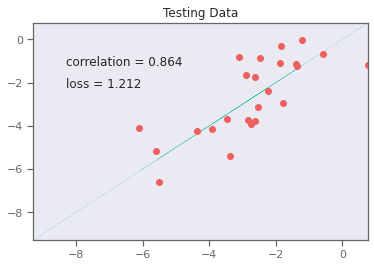

In [570]:
yhat = test_x @ w + b
plt.plot(test_y, test_y, ':', linewidth=0.2)
plt.plot(test_y, yhat, 'o')
plt.xlim(min(test_y), max(test_y))
plt.ylim(min(test_y), max(test_y))
plt.text(min(test_y) + 1, max(test_y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(test_y) + 1, max(test_y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.show()

We've plotted above the loss on our training data and testing data. The loss on training goes down after each step, as we would expect for gradient descent. However, the testing loss goes down and then starts to go back up. This is called **overfitting**. This is one of the key challenges in ML and we'll often be discussing it.

Overfitting is a result of training for too many steps or with too many parameters, resulting in our model learning the **noise** in the training data. The noise is specific for the training data and when computing loss on the test data there is poor performance. 

To understand this, let's first define noise. Assume that there is a "perfect" function $f(\vec{x})$ that can compute labels from features. Our model is an estimate $\hat{f}(\vec{x})$ of that function. Even $f(\vec{x})$ will not reproduce the data exactly becuase our features do not capture everything that goes into solubility and/or there is error in the solbulity measurements themsevles. Mathematically,

\begin{equation}
    y = f(\vec{w}) + \epsilon
\end{equation}

where $\epsilon$ is a random number with mean 0 and unknown standard deviation $\sigma$. $\epsilon$ is the noise. When fitting our function, $\hat{f}(\vec{x})$ the noise is fixed because our labels $y$ are fixed. That means we can accidentally learn approximate the sum of $f(\vec{x})$ and the noise ${\epsilon_i}$ instead of only capturing $f(\vec{x})$. The noise is random and uncorrelated with solubility. When we move to our testing dataset, this noise changes because we have new data and our model's effort to reproduce noise is useless because the new data has new noise. This leads to worse performance. 


Overfitting arises when three things happen: you have noise, you have extra features or some part of your features are not correlated with the labels, and your training has converged (your model fit is at the global minimum). This last one is what we saw above. Our model wasn't overfit after about 100 steps (the training and testing loss were both decreasing), but then they starting going in opposite directions. Let's see how these things interplay to lead to overfitting in an example where we can exactly control the features and noise. 

### Overfitting with Synthetic Data

We'll explore overfitting in a synthetic example. Our real function we're trying to learn will be:

\begin{equation}
 f(x) = x^3 - x^2 + x - 1
\end{equation}

which we can rewrite as a linear model:

\begin{equation}
  f(\vec{x}) = \vec{w}\cdot\vec{x} = [1, -1, 1, -1]\cdot[x^3, x^2, x, 1]
\end{equation}
where our features are $[x^3, x^2, x, 1]$. To do our split, we'll take the positive points as training data and the negative as testing data. To avoid the issue of convergence, we will use least squares to fit these models instead of gradient descent. 

Let's establish a benchmark. How well can a model do without noise? We'll use 10 training data points and 10 testing data points. We'll put our testing data in the center of the polynomial.

Expand the python cells below to see how this is implemented.

In [571]:
# generate data from polynomial
N = 20
syn_x = np.linspace(-3, 3, N)
# create feature matrix
syn_features = np.vstack([syn_x**3, syn_x**2, syn_x, np.ones_like(syn_x)]).T
syn_labels = syn_x **3 - syn_x**2 + syn_x - 1


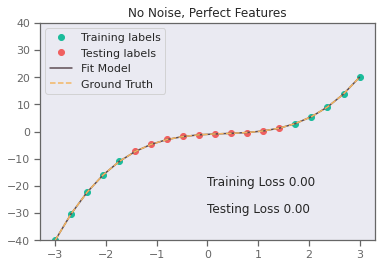

In [572]:
# split data into train/test
indices = list(range(0, N // 4)) + list(range(3 * N // 4, N))
test_indices = list(range(N // 4, 3 * N // 4))
train_x = syn_features[indices]
train_y = syn_labels[indices] 
test_x = syn_features[test_indices]
test_y = syn_labels[test_indices]

# fit using numpy least squares method.
w, *_ = np.linalg.lstsq(train_x, train_y)

# plotting code
plt.plot(syn_x[indices], train_y, 'o', label='Training labels')
plt.plot(syn_x[test_indices], test_y, 'o', label='Testing labels')
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label='Fit Model')
plt.plot(syn_x, syn_labels, '--', label='Ground Truth')
plt.text(0, -20, f'Training Loss {loss(w,0,train_x, train_y):.2f}')
plt.text(0, -30, f'Testing Loss {loss(w,0, test_x, test_y):.2f}')
plt.legend()
plt.title('No Noise, Perfect Features')
plt.show()

There is no overfitting and the regssion is quite accurate without noise. Now we'll add noise to both the training labels. 

In [573]:
train_y = train_y + np.random.normal(scale=5, size=train_y.shape)

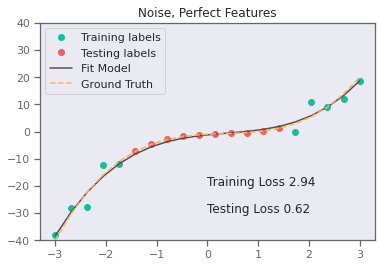

In [574]:
w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, 'o', label='Training labels')
plt.plot(syn_x[test_indices], test_y, 'o', label='Testing labels')
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label='Fit Model')
plt.plot(syn_x, syn_labels, '--', label='Ground Truth')
plt.text(0, -20, f'Training Loss {loss(w,0,train_x, train_y):.2f}')
plt.text(0, -30, f'Testing Loss {loss(w,0, test_x, test_y):.2f}')
plt.legend()
plt.title('Noise, Perfect Features')
plt.show()

Adding noise reduces the accuracy on the training data. The testing labels have no noise and the model is not overfit, so the accuracy is good for the testing loss.

Now we'll try adding redundant features. Our new features will be $[x^6, x^5, x^4, x^3, x^2, x, 1]$. Still less than our data point number but not all features are necessary to fit the labels.

In [575]:
syn_features = np.vstack([syn_x**i for i in range(7)]).T

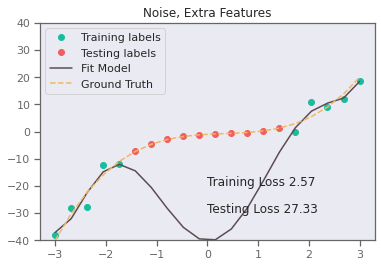

In [576]:
train_x = syn_features[indices]
test_x = syn_features[test_indices]
test_y = syn_labels[test_indices]

w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, 'o', label='Training labels')
plt.plot(syn_x[test_indices], test_y, 'o', label='Testing labels')
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label='Fit Model')
plt.plot(syn_x, syn_labels, '--', label='Ground Truth')
plt.text(0, -20, f'Training Loss {loss(w,0,train_x, train_y):.2f}')
plt.text(0, -30, f'Testing Loss {loss(w,0, test_x, test_y):.2f}')
plt.legend(loc='upper left')
plt.title('Noise, Extra Features')
plt.show()

This is an overfit model. The training loss went down (note the noise was the same in the previous two examples), but at the expense of a large decrease in testing loss. This wasn't possible in the previous example because over-fitting to noise wasn't feasible when each feature was necessary to capture the correlation with the labels. 

Let's see an example where the feature number is the same but they aren't perfectly correlated with labels, meaning we cannot match the labels even if there was no noise. 

In [577]:
syn_features = np.vstack([syn_x**2, syn_x, np.exp(-syn_x**2), np.cos(syn_x), np.ones_like(syn_x)]).T

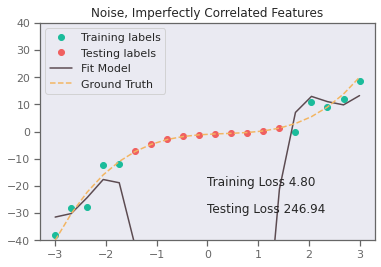

In [578]:
train_x = syn_features[indices]
test_x = syn_features[test_indices]

w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, 'o', label='Training labels')
plt.plot(syn_x[test_indices], test_y, 'o', label='Testing labels')
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label='Fit Model')
plt.plot(syn_x, syn_labels, '--', label='Ground Truth')
plt.text(0, -20, f'Training Loss {loss(w,0,train_x, train_y):.2f}')
plt.text(0, -30, f'Testing Loss {loss(w,0, test_x, test_y):.2f}')
plt.legend(loc='upper left')
plt.title('Noise, Imperfectly Correlated Features')
plt.show()

In [591]:
# redo
N = 20
syn_x = np.linspace(-3, 3, N)
# create feature matrix
syn_labels = syn_x **3 - syn_x**2 + syn_x - 1 + np.random.normal(size=N)
syn_features = np.vstack([syn_x]).T

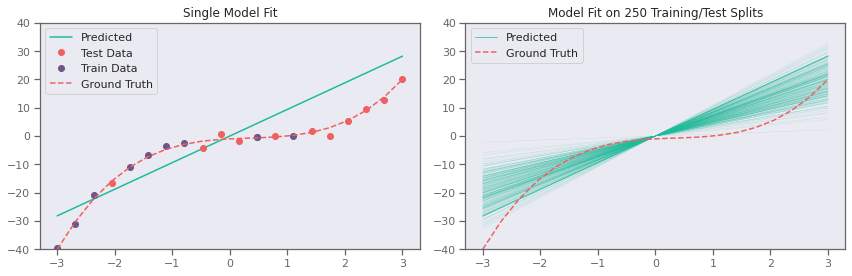

In [592]:
from myst_nb import glue
L = 250
test_vals = np.empty((N,L))
test_vals[:] = np.nan
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for i in range(L):
    indices = np.random.choice(range(N), size=N // 2)
    test_indices = list(set(range(N)) - set(indices))
    train_x = syn_features[indices]
    train_y = syn_labels[indices]
    test_x = syn_features[test_indices]
    test_y = syn_labels[test_indices]
    w, *_ = np.linalg.lstsq(train_x, train_y)
    test_vals[test_indices, i] = jnp.dot(test_x, w)
    axs[1].plot(syn_x, jnp.dot(syn_features, w), color='C0', alpha=0.7, linewidth=0.1)
axs[1].plot(syn_x, jnp.dot(syn_features, w), color='C0', alpha=0.7, linewidth=1, label='Predicted')    
axs[0].plot(syn_x, jnp.dot(syn_features, w), color='C0', label='Predicted')    
axs[0].plot(syn_x[test_indices], test_y, 'o', color='C1', label='Test Data')    
axs[0].plot(syn_x[indices], train_y, 'o', color='C4', label='Train Data')    
axs[1].set_ylim(-40, 40)
axs[0].set_ylim(-40, 40)
axs[1].plot(syn_x, syn_x **3 - syn_x**2 + syn_x - 1, '--', label='Ground Truth', color='C1')
axs[0].plot(syn_x, syn_x **3 - syn_x**2 + syn_x - 1, '--', label='Ground Truth', color='C1')
axs[1].legend()
axs[0].legend()
axs[0].set_title('Single Model Fit')
axs[1].set_title(f'Model Fit on {L} Training/Test Splits')

plt.tight_layout()
glue('low_var', plt.gcf(), display=False)
plt.show()

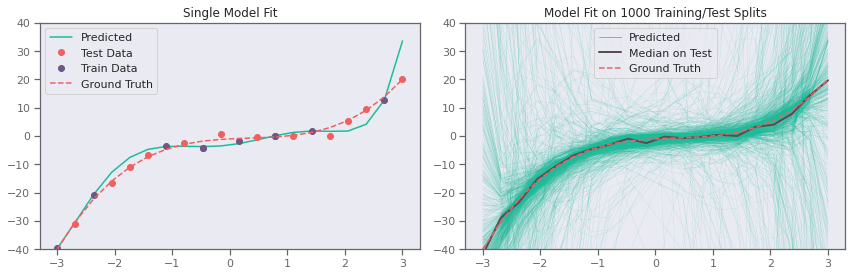

In [601]:
syn_features = np.vstack([syn_x**i for i in range(7)]).T
L = 1000
test_vals = np.empty((N,L))
test_vals[:] = np.nan
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for i in range(L):
    indices = np.random.choice(range(N), size=N // 2)
    test_indices = list(set(range(N)) - set(indices))
    train_x = syn_features[indices]
    train_y = syn_labels[indices]
    test_x = syn_features[test_indices]
    test_y = syn_labels[test_indices]
    w, *_ = np.linalg.lstsq(train_x, train_y)
    test_vals[test_indices, i] = jnp.dot(test_x, w)
    axs[1].plot(syn_x[test_indices], jnp.dot(test_x, w), color='C0', alpha=0.7, linewidth=0.1)
axs[1].plot(syn_x, jnp.dot(syn_features, w), color='C0', alpha=0.7, linewidth=1, label='Predicted')    
axs[1].plot(syn_x, np.nanmedian(test_vals, axis=1), color='C2', alpha=1.0, linewidth=2, label='Median on Test')    
axs[0].plot(syn_x, jnp.dot(syn_features, w), color='C0', label='Predicted')    
axs[0].plot(syn_x[test_indices], test_y, 'o', color='C1', label='Test Data')    
axs[0].plot(syn_x[indices], train_y, 'o', color='C4', label='Train Data')    
axs[1].set_ylim(-40, 40)
axs[0].set_ylim(-40, 40)
axs[1].plot(syn_x, syn_x **3 - syn_x**2 + syn_x - 1, '--', label='Ground Truth', color='C1')
axs[0].plot(syn_x, syn_x **3 - syn_x**2 + syn_x - 1, '--', label='Ground Truth', color='C1')
axs[1].legend()
axs[0].legend()
axs[0].set_title('Single Model Fit')
axs[1].set_title(f'Model Fit on {L} Training/Test Splits')
plt.tight_layout()
glue('high_var', plt.gcf(), display=False)
plt.show()

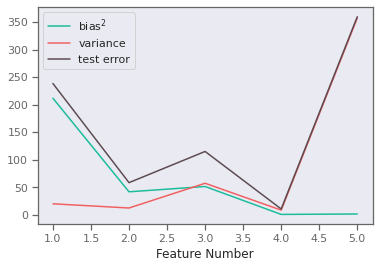

In [582]:
F = 6
bias = []
var = []
test_error = []
L = 2500
for f in range(1, F):
    syn_features = np.vstack([syn_x**i for i in range(f)]).T
    test_vals = np.empty((L, N))
    test_vals[:] = np.nan 
    for i in range(L):    
        indices = np.random.choice(range(N), size=N // 2)
        test_indices = list(set(range(N)) - set(indices))
        train_x = syn_features[indices]
        train_y = syn_labels[indices]
        test_x = syn_features[test_indices]
        test_y = syn_labels[test_indices]
        w, *_ = np.linalg.lstsq(train_x, train_y)
        test_vals[i, test_indices] = np.clip(np.dot(test_x, w), -1000, 1000)
    ed = np.nanmean(test_vals, axis=0)
    bias.append(np.mean((ed - (syn_x **3 - syn_x**2 + syn_x - 1))**2))
    test_error.append(np.nanmean((test_vals - syn_labels)**2))
    var.append(np.nanmean((ed - test_vals)**2))
plt.plot(range(1,F), bias, label='bias$^2$')
plt.plot(range(1,F),var, label='variance')
plt.plot(range(1,F),test_error, label='test error')
plt.xlabel('Feature Number')
plt.legend()
glue('bv', plt.gcf(), display=False)
plt.show()

It's arguable if this is overfitting. Yes, the testing loss is high but it could be argued it's more to do with the poor feature choice. In any case, even though our parameter number is less than the clear cut case above, there is still left over variance in our features which can be devoted to fitting noise.


Would there overfitting with fewer features that are perfectly correlated with labels?

```{admonition} Answer
:class: dropdown
Yes, because we can use the left over variance in our features to fit noise. 
```


### Overfitting Conclusion

* Overfitting is inevitable in real data because we cannot avoid noise and rarely have the perfect features. 
* Overfitting can be assessed by splitting our data into a train and test split, which mimics how we would use the model (i.e., on unseen data). 
* Overfitting is especially affected by having too many features or features that don't correlate well with the labels. 
* We can identify overfitting from a loss curve which shows the testing loss rising while training loss is decreasing. 

## Exploring Effect of Feature Number

We've seen that overfitting is sensitive to the number and choice of features. Feature selection is a critical decision in supervised learning. We'll return the solubility dataset to discuss this. It has 17 molecular descriptors, but these are just a small fraction of the possible molecular descriptors that can be used. For example, there is a software called [Dragon](https://chm.kode-solutions.net/products_dragon.php) that can compute over 5,000 descriptors. You can also create linear combinations of descriptors and pass them through functions. Then there is the possibility of experimental data, data from molecular simulations, and from quantum caclulations. There is essentially an unlimited number of possible molecular descriptors. We'll start this chapter by exploring what effect the feature number has on the data.


```{margin}
**Descriptor** is chemistry and materials specific word for feature. It pre-dates the word features and comes from the field of "qauntitative-structure activity relationship" (QSAR), which has a long history in drug design and molecular design.
```



We are now working with a real dataset, which means there is randomness from which features we choose, which training data we choose, and randonmness in the lables themsevles. In the results below, they are averaged over possible features and possible training data splits to deal with this. Thus the code is complex. You can see it on the Github repository, but I've omitted it for simplicity.



```{glue:figure} small_feature_number
----
name: small_feature_number
----
Effect of feature number on 25 training data points averaged over 10 data samples/feature choices combinations. 
```


{numref}`small_feature_number` shows the effect of choosing different features on both the loss on training data and the loss on test data. There are three regimes in this plot. At 1-3 features, we are **underfit** meaning both the training and testing losses could be improved with more features or more training. In this case, it is because there are too few features. Until about 10 features, we see that adding new features slightly improves training data but doesn't help test data meaning we're probably slightly overfitting. Then at 10, there is a large increase as we move to the overfit regime. Finally at about 30 features, our model is no longer converging and training loss rises because it is too difficult to train the increasingly compelx model. "Difficult" here is a relative term; you can easily train for more time on this simple model but this is meant as an example. 


```{glue:figure} large_feature_number
------
name: large_feature_number
-------

Effect of feature number on 250 training data points averaged over 10 data samples/feature choices combinations. 
```

{numref}`large_feature_number` shows the same analysis but for 250 train and 250 test data. The accuracy on test data is better (about 1.9 vs 2.5). There is not much overfitting visible here. The model is clearly underfit until about 10 features and then each additional feature has little effect. Past 20 features, we again see an underfit because the model is not trained well. This could fixed by adding more training steps. 

------

Increasing feature numbers is useful up to a certain point. Although some methods are unstable when the number of features is exactly the same as the number of data points, there is reason overfitting begins at or near feature numbers equal to the number of data points. Overfitting can disappear at large feature numbers because of model size and complexity. Here there is also a risk of underfitting. 

The risk of overfitting is lower as your dataset size increases. The reason for this is that the noise becomes smaller than the effect of labels on training as you increase data points. Recall from the Central Limit Theorem that reducing noise by a factor of 10 requires 100 more times data, so this is not as efficient as choosing better features. Thinking about these trade-offs, to double your feature number you should quadrouble the number of data points to reduce the risk of overfitting. Thus there is a strong relationship between how complex your model can be, the achievable accuracy, the data required, and the noise in labels. 

In [583]:
# get K samples of N data points
N = 25
K = 10
train_data = [np.empty((K, N, len(feature_names))), np.empty((K, N))]
test_data = [np.empty((K, N, len(feature_names))), np.empty((K, N))]

for i in range(K):
    sample = soldata.sample(N, replace=False)
    train_data[0][i] = sample[feature_names].values
    train_data[1][i] = sample['Solubility'].values              
    sample = soldata.sample(N, replace=False)
    test_data[0][i] = sample[feature_names].values
    test_data[1][i] = sample['Solubility'].values

In [584]:
def adam_fit(ftransform, x, y, test_x, test_y, rng):
    x = jnp.dot(x, ftransform)
    test_x = jnp.dot(test_x, ftransform)
    w, *_ = jax.numpy.linalg.lstsq(x, y)    
    b = jnp.mean(y - jnp.dot(x, w))
    if ftransform.shape[1] >= x.shape[1]:
        opt_init, opt_update, get_params = optimizers.adam(step_size=0.2)    
        opt_state = opt_init((w, b))    
        for i in range(100):
            p = get_params(opt_state)
            grad = loss_grad(*p, x, y)
            opt_state = opt_update(i, grad, opt_state)
        w, b = get_params(opt_state) 
    return loss(w, b, test_x, test_y), loss(w, b, x, y)

def fit(ftransform, x, y, test_x, test_y):
    x = jnp.dot(x, ftransform)
    test_x = jnp.dot(test_x, ftransform)
    w, *_ = jax.numpy.linalg.lstsq(x, y)    
    b = jnp.mean(y - jnp.dot(x, w))
    return loss(w, b, test_x, test_y), loss(w, b, x, y)

In [585]:
feature_sizes = list(range(1, N)) + list(range(N, 2 * N, 5))
max_features = max(feature_sizes)
fts = np.zeros((len(feature_sizes), K, len(feature_names), max_features))
for i,f in enumerate(feature_sizes):
    fts[i, :, :, :f] = np.random.normal(size=(K, len(feature_names), f))

In [586]:
rng = jax.random.PRNGKey(0)
vfit = jax.vmap(adam_fit, (0, 0, 0, 0, 0, None))
losses = []
for i,f in enumerate(feature_sizes):
    l = jnp.mean(vfit(fts[i], *train_data, *test_data, rng), axis=1)
    losses.append(l)

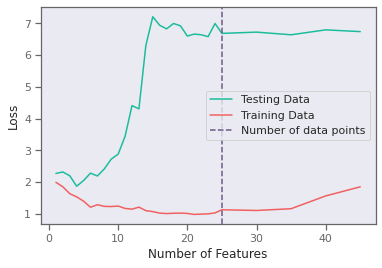

In [587]:
from myst_nb import glue

lo = plt.plot(feature_sizes, losses)
plt.xlabel('Number of Features')
plt.ylabel('Loss')
vo = plt.axvline(x=N, color=color_cycle[-1], linestyle='--')
plt.legend(lo + [vo], ('Testing Data', 'Training Data', 'Number of data points'))
glue('small_feature_number', plt.gcf(), display=False)
plt.show()

In [588]:
# get K samples of N data points
N2 = 500
K = 10

fts = np.zeros((len(feature_sizes), K, len(feature_names), max_features))
for i,f in enumerate(feature_sizes):
    fts[i, :, :, :f] = np.random.normal(size=(K, len(feature_names), f))

train_data = [np.empty((K, N2, len(feature_names))), np.empty((K, N2))]
test_data = [np.empty((K, N2, len(feature_names))), np.empty((K, N2))]

for i in range(K):
    sample = soldata.sample(N2, replace=False)
    train_data[0][i] = sample[feature_names].values
    train_data[1][i] = sample['Solubility'].values              
    sample = soldata.sample(N2, replace=False)
    test_data[0][i] = sample[feature_names].values
    test_data[1][i] = sample['Solubility'].values

losses_500 = []
for i,f in enumerate(feature_sizes):
    l = jnp.mean(vfit(fts[i], *train_data, *test_data, rng), axis=1)
    losses_500.append(l)

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 30
26 35
27 40
28 45


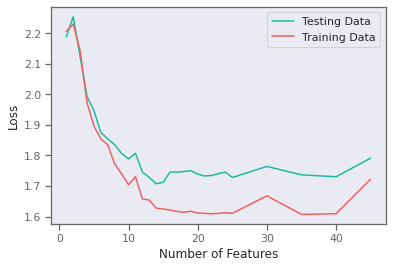

In [589]:
lo = plt.plot(feature_sizes, losses_500)
plt.xlabel('Number of Features')
plt.ylabel('Loss')
plt.legend(lo, ('Testing Data', 'Training Data'))
glue('large_feature_number', plt.gcf(), display=False)
plt.show()

## Bias Variance Decomposition

We will now try to be more systematic about this difference in model performance between training and testing data. Consider an unseen label $y$ and our model $\hat{f}(\vec{x})$. Our error on the unseen label is:

```{math}
:label: exp_error
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right]
```

What is the expectation over? For now, let's just assume the only source of randomness is in the noise from the label (recall $y = f(\vec{x}) + \epsilon$). Then our expression becomes:

\begin{equation}
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right] =  E\left[y^2\right] + E\left[\hat{f}(\vec{x})^2\right] - E\left[y\hat{f}(\vec{x})\right]
\end{equation}

\begin{equation}
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right] =  E\left[\left(f(\vec{x}) - \epsilon\right)^2\right] + \hat{f}(\vec{x})^2 - E\left[\left(f(\vec{x}) - \epsilon\right)\right]\hat{f}(\vec{x})
\end{equation}

I have dropped the expectations over deterministic expression $\hat{f}$. You can continue this, again dropping any $E[f(\vec{x})]$ terms and using the definition of $\epsilon$, a zero mean normal distribution with standard deviation $\sigma$. You will arrive at:

```{math}
:label: exp_error_noD
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right] = \left(f(\vec{x}) - \hat{f}(\vec{x})\right)^2 + \sigma^2
```

This expression means the best we can do on an unseen label is the noise of the label. This is very reasonable, and probably matches your intuition. The best you can do is match exactly the noise in the label when you have a perfect agreement between $f(\vec{x})$  and $\hat{f}(\vec{x})$

*However, this analysis did not account for the fact our choice of training data is random*. Things become more complex when we consider that our choice of training data is random. Return to Equation {eq}`exp_error` and now replace $\hat{f}\left(\vec{x}\right)$ with $\hat{f}\left(\vec{x}; \mathbf{D}\right)$ where $\mathbf{D}$ is a random variable indicating the random data sample. You can find a complete derivation on [Wikipedia](https://en.wikipedia.org/wiki/Bias-variance_tradeoff). The key change is that  $\left(f(\vec{x}) - \hat{f}\left(\vec{x}; \mathbf{D}\right)\right)^2$ is now a random variable. Equation {eq}`exp_error_noD` becomes:

```{math}
:label: bv
    E\left[\left(y - \hat{f}(\vec{x})\right)^2\right] = E\left[f(\vec{x}) - \hat{f}\left(\vec{x}; \mathbf{D}\right)\right]^2 + 
    E\left[\left(E\left[\hat{f}\left(\vec{x}; \mathbf{D}\right)\right] - \hat{f}\left(\vec{x}; \mathbf{D}\right)\right)^2\right] + \sigma^2
```

This expression is the most important equation for understanding ML and deep learning training. The first term in this expression is called **bias** and captures how far away our model is from the correct function $f(\vec{x})$. This is the expected (average) loss we get given a random dataset evaluated on a new unseen data point. You may think this the most important quantity -- expected difference between the true function and our model on a new data point. However, bias does not determine the expected error on an unseen data point alone, there other terms.

```{margin}
In Equation{eq}`bv` $\vec{x}$ is a fixed quantity, unlike what you may be used to in probability. The actual random variables are $\epsilon$ (noise in label) and $\mathbf{D}$ (our chosen training data).
```

The second term is surprising. It is called the **variance** and captures how much change at the unseen data point $\vec{x},y$ there is due to changes in the random variable $\mathbf{D}$. What is suprising is that the expected loss depends on the variance of the learned model. Think carefully about this. A model which is highly sensitive to which training data is chosen has a high expected error on test data. Furthermore, remember that this term **variance** is different than variance in a feature. It captures how the model value changes at a paritcular $\vec{x}$ as a function of changing the training data.


```{glue:figure} low_var
----
name: low_var
----
A single feature fit to the polynomial model example above. The left panel shows a single train/test split and the resulting model fit. The right panel shows the result of many fits. The model variance is the variacne across each of those model fits and the bias is the agreement of the average model. It can be seen that this model has low variance but poor average agreement (high bias). 
```


These three terms: noise, bias, and variance set the minimum value for test error. Noise is set by your data and not controlloble. However, bias and variance are controllable. What does a high bias, low variance model look like? A 1D linear model is a good example. See {numref}`low_var`. It has one parameter so a sample of data points gives a conisistent estimate. However, a 1D model cannot capture the true $f(\vec{x})$ so it has a large average error (bias) at a given point. What does a low bias, high variance model look like? An overfit model like the one shown in {numref}`high_var`. It has extreme outliers on test data, but on average it actually has a low bias.


```{glue:figure} high_var
----
name: high_var
----
A 7 feature fit to the polynomial model example above. The left panel shows a single train/test split and the resulting model fit. The right panel shows the result of many fits. The model variance is the variance across each of those model fits and the bias is the agreement of the average model. It can be seen that this model has high variance but good average agreement (low bias). 
```

**The Tradeoff**


```{glue:figure} bv
----
name: bv
----
The bias, variance, and fit on test values for the polynomial example avearged across 2,500 train/test splits. As the number of features incerases, variance increases and bias decreases. There is a minum at 4 features. The plot stops at 5 because the variance becomes very large beyond 5.
```

The way to change bias and variance is through **model complexity**, which is feature number in our linear models. Increasing model complexity reduces bias and increases variance. There is an optimum for our polynomial example, shown in {numref}`bv`. Indeed this is true of most ML models, although it can be difficult to cleanly increase model complexity and keep training converged. However, this is [not typically true in deep learning with neural networks](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update).

```{note}
The bias--variance tradeoff for model complexity is based on experience. The decomposition above does not imply it. Intentionally underfitting, adding noise, and exchanging one feature for another are all ways to affect bias and variance without adjusting complexity. Also, sometimes you can just improve both with better models. 
```

The bias--variance tradeoff is powerful for explaining the intuition we've learned from examples above. Large datasets reduce model variance, explaining why it is possible to increase model complexity to improve model accuracy only with larger datasets. Overfitting reduces bias at the cost of high variance. Not training long enough increases bias, but reduces variance as well since you can only move so far from your starting parameters.

## Strategies to Assess Models

* Data split, CV, LOO, 

## Regularization

Ridge - L2
Lasso - L1

##  Training Data Distribution

Extrapolating. Leave one class out

https://www.nature.com/articles/s41467-020-17112-9


## Quantifying Uncertainty

Jacknife, Bootstrap, Jacknife+ https://arxiv.org/abs/1905.02928

## Exercises

### Overfitting

What happens if we have redundant features but no noise? Is it possible to overfit?

## Cited References

```{bibliography} references.bib
```